## Extra: Blending

In [3]:
from IPython.display import Image
import cv2
import numpy as np
from homography import *
from scipy.spatial import distance


def apply_homography_bi_weights(img1, img2, H, output_shape=None, offset=(0,0)):
    if(output_shape):
        output_img = np.zeros(output_shape, img1.dtype)
    else:
        output_img = np.zeros_like(img1)

    (offset_y, offset_x) = offset
    (height, width, channels) = output_img.shape
    (h1, w1, c1) = img1.shape
    (h2, w2, c2) = img2.shape
    
    # Compute weights
    W1 = np.zeros((h1,w1), np.float32)
    W2 = np.zeros((h2,w2), np.float32)
    center1 = (h1/2.,w1/2.)
    center2 = (h2/2.,w2/2.)
    norm1 = distance.euclidean(center1,(0,0))
    norm2 = distance.euclidean(center2,(0,0))
    
    for y in range(0, h1):
        for x in range(0, w1):
            W1[y,x] = norm1-distance.euclidean(center1,(y,x))/norm1
    for y in range(0, h2):
        for x in range(0, w2):
            W2[y,x] = norm2-distance.euclidean(center2,(y,x))/norm2

    
    for y in range(0, height):
        for x in range(0, width):
            (y_pos, x_pos) = calculate_coords(y-offset_y, x-offset_x, H)
            y1 = int(y_pos)
            y2 = y1+1
            x1 = int(x_pos)
            x2 = x1+1

            if  between(y1, 0, h2) \
            and between(x1, 0, w2) \
            and between(y2, 0, h2) \
            and between(x2, 0, w2):
                for i in range(0, channels):
                    v2 = bilinear_interpolation(
                        y_pos,x_pos,
                        y1,y2,x1,x2,
                        img2[y1, x1, i],
                        img2[y1, x2, i],
                        img2[y2, x1, i],
                        img2[y2, x2, i]
                    )
                    
                    weight2 = bilinear_interpolation_float(
                        y_pos,x_pos,
                        y1,y2,x1,x2,
                        W2[y1, x1],
                        W2[y1, x2],
                        W2[y2, x1],
                        W2[y2, x2]
                    )

                    v1 = 0
                    weight1 = 0.00001
                    if between(y-offset_y, 0, h1) \
                    and between(x-offset_x, 0, w1): 
                        v1 = img1[y-offset_y, x-offset_x, i]
                        weight1 = W1[y-offset_y, x-offset_x]
                    factor = 1./(weight1+weight2)
                    output_img[y, x, i] = int(v1*weight1*factor+v2*weight2*factor)
            else:
                if between(y-offset_y, 0, h1) \
                and between(x-offset_x, 0, w1):
                    output_img[y, x] = img1[y-offset_y, x-offset_x]
    return output_img

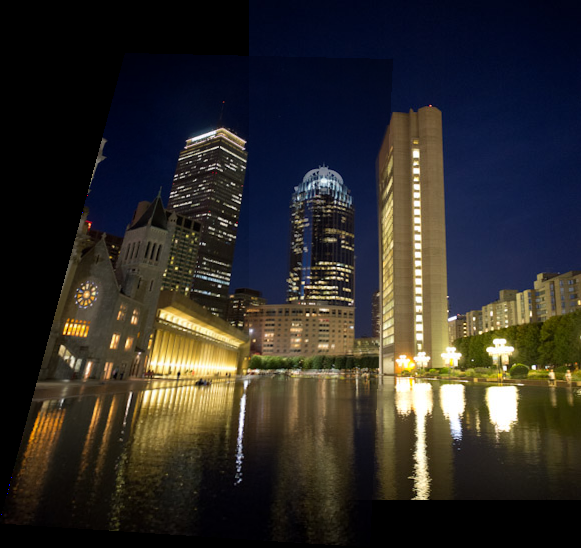

In [5]:
img1 = cv2.imread('images/science-1.jpg')
img2 = cv2.imread('images/science-2.jpg')

pts1 = np.array([[338, 105, 1],[307, 105, 1],[305, 37, 1],[356, 13, 1]])
pts2 = np.array([[326, 306, 1],[296, 304, 1],[297, 235, 1],[347, 217, 1]])

H = find_homography(pts1, pts2)

output_shape, offset = find_bounding_box(img1.shape, img2.shape, H)
output_img = apply_homography_bi_weights(img1, img2, H, output_shape, offset)
output_path = 'output/science_blend.png'
cv2.imwrite(output_path,output_img)
Image(output_path)